In [1]:
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install easyocr
!pip uninstall torchvision
!pip install torchvision==0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pillow==6.1
!pip install autocorrect

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=670cb2a89caab103dc3b2b9e6d9d9cd9e61c32c02ff32b1530dc1df9e5bb0d1f
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

     |████████████████████████████████| 624kB 7.7MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp37-none-any.whl size=621587 sha256=42120c0d712767fca7115d1ec56c899d37cc0b2cbee81b18d72f6f4e59e6078b
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect


In [2]:
!pip install englisttohindi

In [2]:
!mkdir "/usr/share/fonts/truetype/Gargi"

mkdir: cannot create directory ‘/usr/share/fonts/truetype/Gargi’: File exists


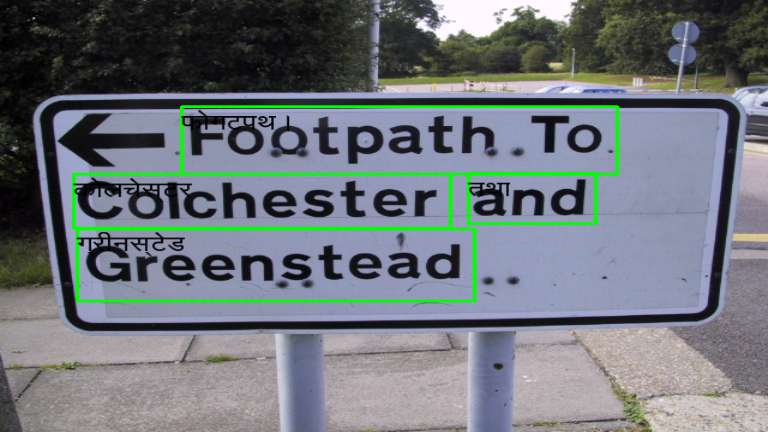

Actual_text_instances:  ['footpath', 'to', 'colchester', 'and', 'greenstead']
Predicted_text_instances:  ['footpath', 'to', 'rochester', 'and', 'greenstead']
correctly_recognized_word:  4
incorrectly_recognized_word 1
Accuracy 80.0


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 15 10:55:27 2021

@author: user
"""

import cv2
import easyocr
from autocorrect import Speller
from PIL import Image
import numpy as np
from englisttohindi.englisttohindi import EngtoHindi 
import PIL
from PIL import Image, ImageDraw, ImageFont
from autocorrect import Speller
import re
from google.colab.patches import cv2_imshow

font_hindi = ImageFont.truetype("/usr/share/fonts/truetype/Gargi/Gargi.ttf",25)

def english_to_hindi(text):
  '''
  This function accepts the english sentence or word,
  and converts it to hindi language
  '''
  
  #creating a EngtoHindi() object 
  res = EngtoHindi(text) 
  
  #converting english text to hindi text
  converted_text = res.convert

  return converted_text

def easyocr_engine(image):
  
  coords = []
  image_copy = image.copy()
  image_copy1 = image.copy()
  reader = easyocr.Reader(['en'])  
  reader = easyocr.Reader(['en'])
  op = reader.readtext(image)
  pred_words=[]
  for i in range(len(op)):
    pts = np.array(op[i][0])
    coords.append(np.int32(pts))
    cv2.polylines(image, np.int32([pts]),True,(0,255,0),2)
    cv2.polylines(image_copy1, np.int32([pts]),True,(0,255,0),2)
    
    ## https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
    cv2.putText(image, op[i][1], (int(op[i][0][0][0]), int(op[i][0][0][1]-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
    pred_words.append(op[i][1])
  
  return image_copy,image_copy1, coords,pred_words

def gt(path):
  li = [];g_t=[]
  f = open(path, "r",encoding='utf-8-sig')
  for x in f:
    li.append(x.split())
  for i in li: ## Taking all the coordinates of text region in that image and appending that in a list boxes
    g_t.append(i[4].replace("\n",""))
  g_t = np.array(g_t)
  
  return g_t

import re
def normalize_string(w):
  try:
    w = re.sub(r"[^a-zA-Z]+", ' ', w)
    return w.lower()
  except:
    pass
def detect_texts(our_image,trans,gt):
      
    ## text detection and recognition
    img,img_det,coords,pred_ = easyocr_engine(our_image) ## img ===> img_with_text; img_det ===> img with bbs for detected text
    
    detected_img_path_n_pts = [] 
    #Removing existing unneeded detetcted cropped image
    for index,pts in enumerate(coords):
      for i in range(len(pts)):
        for j in range(len(pts[i])):
          if (pts[i][j] < 0):
            pts[i][j] = 0
      rect = cv2.boundingRect(pts)
      x,y,w,h = rect
      croped = img[y:y+h, x:x+w].copy()
      pts = pts - pts.min(axis=0)
      mask = np.zeros(croped.shape[:2], np.uint8)
      cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
      dst = cv2.bitwise_and(croped, croped, mask=mask)
      #adding the white background
      bg = np.ones_like(croped, np.uint8)*255
      cv2.bitwise_not(bg,bg, mask=mask)
      dst2 = bg + dst
      img_path = "detected-text/"+str(i)+".png"
      #saving detected cropped text instance image
      cv2.imwrite(img_path, dst2)
      temp,n = (x,y),img_path
      detected_img_path_n_pts.append(temp)
    
    pred_words = normalize_string(" ".join(pred_).lower()).split()

    spell = Speller(lang='en')
    for i in range(len(pred_words)):
        pred_words[i] = spell(pred_words[i])

    if trans:
      #Translating predicted text to specified language
      pred_trans = []
      for i in pred_:
        if i.isdigit():
          pred_trans.append(i)
        else:
          pred_trans.append(english_to_hindi(i))

      img_pil = Image.fromarray(img_det) ##img_det is image with only bbs
      draw = ImageDraw.Draw(img_pil)

      for i in range(len(pred_trans)):
        draw.text(detected_img_path_n_pts[i], pred_trans[i], font=font_hindi,fill='black')
      img_det = np.array(img_pil)
    else:
      for i in range(len(pred_)):
        cv2.putText(img_det, pred_[i], detected_img_path_n_pts[i], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
    
    
    actual = normalize_string("|".join(list(gt)).lower()).split()
    #print(actual)
    y_true = 0
    for i in pred_words:
      for j in actual:
        if i == j:
          y_true +=1
    
    
    if trans:
      return img_det,actual,pred_words,y_true,len(actual)-y_true,(y_true*100)/(len(actual)),pred_trans
    return img_det,actual,pred_words,y_true,len(actual)-y_true,(y_true*100)/(len(actual)),[]
image = cv2.imread(r"/content/100.jpg")
result_img,Actual_text_instances,Predicted_text_instances,correctly_recognized_word,incorrectly_recognized_word,Accuracy,pred_trans= detect_texts(image,trans=True,gt=gt(r"/content/gt_100.txt"))
cv2_imshow(cv2.resize(result_img,(int(1280*0.6),int(720*0.6))))

print("Actual_text_instances: ",Actual_text_instances)
print("Predicted_text_instances: ",Predicted_text_instances)
print("correctly_recognized_word: ",correctly_recognized_word)
print("incorrectly_recognized_word" ,incorrectly_recognized_word)
print("Accuracy", Accuracy)


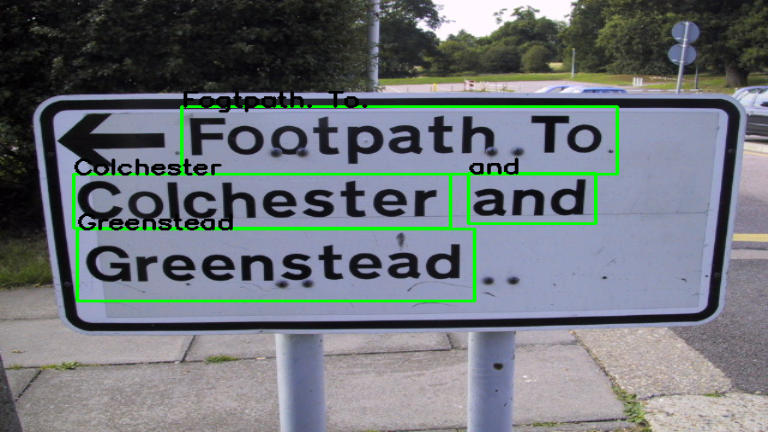

Actual_text_instances:  ['footpath', 'to', 'colchester', 'and', 'greenstead']
Predicted_text_instances:  ['footpath', 'to', 'rochester', 'and', 'greenstead']
correctly_recognized_word:  4
incorrectly_recognized_word 1
Accuracy 80.0


In [10]:
image = cv2.imread(r"/content/100.jpg")
result_img,Actual_text_instances,Predicted_text_instances,correctly_recognized_word,incorrectly_recognized_word,Accuracy,pred_trans= detect_texts(image,trans=False,gt=gt(r"/content/gt_100.txt"))
cv2_imshow(cv2.resize(result_img,(int(1280*0.6),int(720*0.6))))

print("Actual_text_instances: ",Actual_text_instances)
print("Predicted_text_instances: ",Predicted_text_instances)
print("correctly_recognized_word: ",correctly_recognized_word)
print("incorrectly_recognized_word" ,incorrectly_recognized_word)
print("Accuracy", Accuracy)
